
# Advanced Data Science Capstone

## Air pollution and prevalence of bronchial asthma in Germany  

## Feature Creation and Feature engineering, Pandas

### The deliverables
The deliverables of the current stage:

 - Pandas data frame with disease prevalence column, county id, and features extracted from air pollution data series for sensors located in corresponding counties

###  Feature creation
The basic features for air pollution levels are

 - Number of hours when pollutant concentration exceeded some certain value (percentile-based features)
 - Mean or Median concentration of the pollutant
 
###  Feature quality check

 - Feature variance
 - Feature cross-correlation matrix
 
 First of all the necessary libraries and the datasets preprocessed at the ETL stage loaded:

In [1]:
# Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
# Files:
SensorLocation = pd.read_csv('Capstone.ETL/Capstone.etl.SensorLocationCSV.1.0.csv')
dfAsthma = pd.read_csv('Capstone.ETL/Capstone.etl.dfAsthmaCSV.1.0.csv')
dffAll = pd.read_csv('Capstone.ETL/Capstone.etl.wideCSV.1.0.gzip', compression='gzip', index_col=None)
dfDisease = dfAsthma

###  Feature creation

The following features will be generated:
 - Pollutant concentration features
   - Average concentration of every kind of pollutant over the year (average over all sensors within the county)
   - 75th percentile of every kind pollutant over the year, that is also proportional to the number of hours when pollutant concentration exceeded some certain value
 - Health indicator features
   - presense of the county in 50th, 75th or 95th percentile of bronchial asthma prevalence over the counties
 
#### Mean pollutant concentration over the year in selected county
Starting from the "wide" Pandas DataFrame **dffAll** the quantity can be straightforward extracted using *.describe()* method via
*MeanByPollutantCountyID* function:

In [3]:
dffAll.head(3)

dffAllSummary=dffAll.describe()

def MeanByPollutantCountyID(Pollutant, CountyID):
    PollutantMasc='^.{8}' + Pollutant + '_'
# collecting set of all sensors in the given county:    
    CountyStationSet = SensorLocation.loc[SensorLocation['countyid']==CountyID]['SensorID'].tolist()
    if (CountyStationSet == []) or ([col for col in dffAllSummary.columns if re.search('(^.{7})',col).group(1) in CountyStationSet if ('_'+Pollutant+'_') in col] == []):
        return(np.nan)
    try:
        dffAllPollutantCountyID = dffAllSummary[[col for col in dffAllSummary.columns if re.search('(^.{7})',col).group(1) in CountyStationSet]].filter(regex=PollutantMasc,axis=1)
        return(dffAllPollutantCountyID.loc[['mean']].mean(axis=1)[0])
    except:    
        return(np.nan)

In [4]:
ListOfPollutants = ['CO','NO','NO2','NOx','O3','PM1','PM2', 'PM10', 'SO2', 'CHB', 'CH4', 'C8H10', 'CHT', 'CO2']

for pollutant in ListOfPollutants:
    ColIndex=pollutant+'mean'
    dfDisease[ColIndex] =dfDisease.apply(lambda x: MeanByPollutantCountyID(pollutant, x['CountyID']), axis=1)

In [5]:
#dfDisease.head(53)
dfDisease.isna().sum()

CountyID       0
DiseaseR       0
COmean       391
NOmean       348
NO2mean      348
NOxmean      350
O3mean       350
PM1mean      352
PM2mean      383
PM10mean     402
SO2mean      373
CHBmean      391
CH4mean      402
C8H10mean    402
CHTmean      391
CO2mean      402
dtype: int64

From the table above one can see, that only 5 pollutants (*NO, NO2, NOx, O3, PM1*) were measured in about 12% of German counties (total number of counties mentioned in the *bronchial asthma* dataset is 402). Let's take a look, in how many counties all 6 pollutants were measured simultaneously:

In [6]:
FeatureSetDenseMean = dfDisease[['CountyID','DiseaseR','NOmean','NO2mean','NOxmean','O3mean','PM1mean']].dropna().reset_index(drop=True)
#FeatureSetDenseMean.tail(3)
FeatureSetDenseMean.describe()
#FeatureSetDenseMean.isna().sum()

,CountyID,DiseaseR,NOmean,NO2mean,NOxmean,O3mean,PM1mean
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,12808.853659,5.892683,10.915176,16.879199,32.991759,50.300838,15.403850
std,5116.970830,1.083834,12.508702,9.244565,28.075284,8.834913,3.595645
min,1002.000000,4.200000,0.163299,2.155348,2.637490,40.642753,7.460854
25%,14521.000000,5.200000,2.047583,9.932120,12.899541,44.599687,12.520184
50%,15003.000000,5.700000,6.803691,15.297707,25.471797,48.419621,15.508504
75%,16053.000000,6.700000,16.378347,21.588235,41.774936,52.279996,18.206161
max,16077.000000,8.700000,58.916103,41.784301,132.030190,83.072606,21.824518


From the table above one can conclude, that despite only about one eighth of German counties are included into the **FeatureSetDense** dataset, all the measured quantities have good variability. In order to illustrate it, the histograms are plotted:

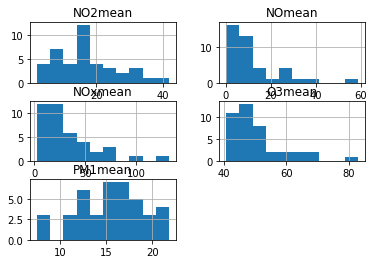

In [7]:
FeatureSetDenseMean.hist(column=['NOmean','NO2mean','NOxmean','O3mean','PM1mean']);

We can also maximize number of counties in the dataset, removing 2 of 5 pollutants. It is found, that for the current dataset it will lead to increase of observations up to 49:

In [8]:
FeatureSetLongMean = dfDisease[['CountyID','DiseaseR','NOmean','NO2mean','PM1mean']].dropna().reset_index(drop=True)
FeatureSetLongMean.columns=['CountyID','DiseaseR','NOmean','NO2mean','PM1mean']
FeatureSetLongMean.describe()

,CountyID,DiseaseR,NOmean,NO2mean,PM1mean
count,49.000000,49.000000,49.000000,49.000000,49.000000
mean,12407.571429,5.875510,12.369953,18.167614,15.935149
std,5314.798471,1.097066,12.653499,9.226942,3.599833
min,1001.000000,4.200000,0.163299,2.155348,7.460854
25%,12065.000000,5.000000,2.246570,11.887994,13.327512
50%,15001.000000,5.700000,7.809633,16.773922,16.167680
75%,16052.000000,6.700000,16.884384,23.017952,18.558537
max,16077.000000,8.700000,58.916103,41.784301,22.832089


Writing feature files:

In [9]:
!rm -rf Capstone.FeatureEng
!mkdir Capstone.FeatureEng
FeatureSetDenseMean.to_csv('Capstone.FeatureEng/Capstone.feature_eng.DenseMean.1.0.csv', index=False)
FeatureSetLongMean.to_csv('Capstone.FeatureEng/Capstone.feature_eng.LongMean.1.0.csv', index=False)

#### Quantile-based features
The 50th and 75th percentiles of every pollutant from the list can also be constructed. 
These features indicate a lower boundary of the pollutant concentration measured during 50% or 25% of the hours with the highest pollutant concentrations correspondingly.  

In [10]:
# Function for Cropping of initial dffAll dataset to columns reflecting measurements 
# of pollutants from ListOfPollutants at counties from ListOfCountyIDs:
def CropPollutantsIDsTS(ListOfPollutants, ListOfCountyIDs):
    CountyStationSet=[]
    dffAllCrop=pd.DataFrame(dffAll['observation_period'])

    for CountyID in ListOfCountyIDs:
        CountyStationSet.extend(SensorLocation.loc[SensorLocation['countyid']==CountyID]['SensorID'].tolist())
    for Pollutant in ListOfPollutants:
        PollutantMasc='^.{8}' + Pollutant + '_' 
        dffAllCrop=dffAllCrop.join(dffAll[[col for col in dffAll.columns if re.search('(^.{7})',col).group(1) in CountyStationSet]].filter(regex=PollutantMasc,axis=1))
    return(dffAllCrop)

# Function for calculating Nth percentiles for pollutants in ListOfPollutants at counties in ListOfCountyIDs:
def ReturnNthPercentilePollutantsIDsTS(Percentile, ListOfPollutants, ListOfCountyIDs):
    CountyStationSet=[]
    NthPercentile=pd.DataFrame()

    for CountyID in ListOfCountyIDs:
        CountyStationSet.extend(SensorLocation.loc[SensorLocation['countyid']==CountyID]['SensorID'].tolist())
    for Pollutant in ListOfPollutants:
        PollutantMasc='^.{8}' + Pollutant + '_'
        NthPercentile[Pollutant] = [(dffAll[[col for col in dffAll.columns if re.search('(^.{7})',col).group(1) in CountyStationSet]].filter(regex=PollutantMasc,axis=1)).stack().reset_index(drop=True).quantile(Percentile/100.0)]
    return(NthPercentile)

# Function for calculating Feature matrix, containing values on Nth percentile for each pollutant from ListOfPollutants
# in counties of interest (in ListOfCountyIDs):
def FeatureMatrixNthPercentile(Percentile, ListOfPollutants, ListOfCountyIDs):
    dffAllCrop=CropPollutantsIDsTS(ListOfPollutants, ListOfCountyIDs)

    FeatureMatrix=pd.DataFrame({'CountyID': dfDisease.loc[dfDisease['CountyID'].isin(ListOfCountyIDs)]['CountyID'], 'DiseaseR': dfDisease.loc[dfDisease['CountyID'].isin(ListOfCountyIDs)]['DiseaseR']}).reset_index(drop=True)
    for Pollutant in ListOfPollutants:
        PollutantNthPercentile=[]
        PollutantMasc='^.{8}' + Pollutant + '_'
        for CountyID in ListOfCountyIDs:
            CountyStationSet=[]
            CountyStationSet.extend(SensorLocation.loc[SensorLocation['countyid']==CountyID]['SensorID'].tolist())

            dffPollutantCounty = dffAllCrop[[col for col in dffAllCrop.columns if re.search('(^.{7})',col).group(1) in CountyStationSet]].filter(regex=PollutantMasc,axis=1)
            NumPollutantStationsAtCounty = dffPollutantCounty.shape[1]
            PollutantNthPercentile.append(dffPollutantCounty.stack().reset_index(drop=True).quantile(Percentile/100.0))
        FeatureMatrix = FeatureMatrix.reset_index(drop=True).join(pd.DataFrame({Pollutant : PollutantNthPercentile}))        
    return(FeatureMatrix)

The same way as it was done for the pollutant mean as a feature, the quantile-based features with two types of pollutant lists (*Dense* and *Long*) and two percentile values (50 and 75) will be created:

In [11]:
ListOfPollutantsDense = ['NO','NO2','NOx','O3','PM1']
ListOfCountyIDsDense = FeatureSetDenseMean['CountyID']
FeatureSetDensePerc50 = FeatureMatrixNthPercentile(50, ListOfPollutantsDense, ListOfCountyIDsDense)
FeatureSetDensePerc75 = FeatureMatrixNthPercentile(75, ListOfPollutantsDense, ListOfCountyIDsDense)

ListOfPollutantsLong = ['NO','NO2','PM1']
ListOfCountyIDsLong = FeatureSetLongMean['CountyID']
FeatureSetLongPerc50 = FeatureMatrixNthPercentile(50, ListOfPollutantsLong, ListOfCountyIDsLong)
FeatureSetLongPerc75 = FeatureMatrixNthPercentile(75, ListOfPollutantsLong, ListOfCountyIDsLong)

FeatureSetDensePerc50.to_csv('Capstone.FeatureEng/Capstone.feature_eng.DensePerc50.1.0.csv', index=False)
FeatureSetDensePerc75.to_csv('Capstone.FeatureEng/Capstone.feature_eng.DensePerc75.1.0.csv', index=False)

FeatureSetLongPerc50.to_csv('Capstone.FeatureEng/Capstone.feature_eng.LongPerc50.1.0.csv', index=False)
FeatureSetLongPerc75.to_csv('Capstone.FeatureEng/Capstone.feature_eng.LongPerc75.1.0.csv', index=False)

In [12]:
#FeatureSetDensePerc50.tail(10)
FeatureSetDensePerc50.head(10)
#FeatureSetLongPerc50.tail(10)
#FeatureSetDensePerc75.tail(10)
#FeatureSetLongPerc75.tail(10)


,CountyID,DiseaseR,NO,NO2,NOx,O3,PM1
0,16072,8.7,1.247400,4.431292,4.432745,61.967087,6.428730
1,16073,8.3,1.247400,10.948489,11.924538,40.665198,15.363067
2,16062,7.7,1.247400,14.630816,15.841152,41.773352,13.519355
3,16054,7.5,1.247400,9.137289,9.904900,65.455000,10.434895
4,16077,7.2,2.277805,14.781091,17.082207,43.207724,13.089457
5,1051,7.1,5.747500,21.096500,31.566000,42.171000,15.805500
6,3360,7.1,0.150000,5.450000,5.970000,50.365000,10.040000
7,7232,6.8,1.247400,10.737166,11.516365,45.287373,12.631050
8,16051,6.8,8.313475,23.733503,36.600473,40.447374,14.764201
9,14713,6.8,14.794000,29.854000,53.293500,39.826000,17.812000


###  Feature transformation

In this part the following notation is used:
 - *X, y* - features and labels of initial feature matrix.
 - *X_train0, X_test0, y_train0, y_test0* initial feature matrix, splitted into train and test sets
 - *X_train, X_test, y_train, y_test* normalized feature matrix, splitted into train and test sets
 - *X_train_XXX, X_test_XXX, y_train_XXX, y_test_XXX* transformed (XXX is the name of transformation) feature matrix, splitted into train and test sets
 

#### Normalization
For use in the machine-learning and especially deep learning frameworks the features have to be normalized:

In [13]:
FeatureSet = FeatureSetDensePerc75

#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.preprocessing import PolynomialFeatures

X, y = FeatureSet.drop(['CountyID', 'DiseaseR'], axis=1), FeatureSet['DiseaseR']
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, random_state=0)


# default scaler: maps to [0:1]
scaler = MinMaxScaler()

scaler.fit(X_train0)
# apply transform
X_train = scaler.transform(X_train0)
X_test  = scaler.transform(X_test0)

# inverse transform
inverse = scaler.inverse_transform(X_train)
# also, maybe lognorm-like distribution can be converted to ~normal with box-cox.

checking inversibility of the scaling procedure:

In [14]:
print(X_train0[0:4])
print(inverse[0:4])

           NO        NO2        NOx         O3        PM1
20   1.153250  17.559000  20.228000  70.274000  19.740500
38   0.616157   9.154189  10.088105  66.458000  16.877212
2    6.258574  24.595467  33.737950  63.655087  19.844954
40  21.613686  31.250275  64.147282  63.220162  23.379356
[[ 1.15325    17.559      20.228      70.274      19.7405    ]
 [ 0.616157    9.15418875 10.08810462 66.458      16.8772125 ]
 [ 6.25857425 24.59546661 33.73795032 63.65508748 19.84495449]
 [21.61368561 31.25027465 64.14728165 63.22016239 23.37935639]]


#### Principal Component Analysis (PCA)
The 5 features from the initial dataset are projected onto 3 eigenvectors, corresponding to 3 extreme eigenvalues of the feature matrix:

In [15]:
pca = decomposition.PCA(n_components=3)
pca.fit(X_train0)
print("PCA explained variance:", pca.explained_variance_ratio_)
X_train_PCA = pca.transform(X_train0)
X_test_PCA = pca.transform(X_test0)

PCA explained variance: [0.97615334 0.01688907 0.00517592]


The PCA analysis shows, that three main features explains waste majority of the variance.

#### Polynomial Features
In order to capture nonlinear behavior of the model,  one can extend the basis set from x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub> to 1, x<sub>1</sub>, x<sub>1</sub><sup>2</sup>, x<sub>2</sub>, x<sub>2</sub><sup>2</sup>, x<sub>3</sub>, x<sub>3</sub><sup>2</sup>:

In [16]:
FeatureSet = FeatureSetLongPerc50
X, y = FeatureSet.drop(['CountyID', 'DiseaseR'], axis=1), FeatureSet['DiseaseR']
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, random_state=0)


poly = PolynomialFeatures(2)
poly.fit_transform(X_train0)
X_train_UpToSquares = poly.transform(X_train0)
X_test_UpToSquares = poly.transform(X_test0)

In order to treat potential interactions between the feature variables,  one can extend the basis set from x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub> to 1, x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub>, x<sup>1</sup>x<sub>2</sub>, x<sub>1</sub>x<sub>3</sub>, x<sub>2</sub>x<sub>3</sub>, x<sub>1</sub>x<sub>2</sub>x<sub>3</sub>:

In [17]:
poly = PolynomialFeatures(degree=3, interaction_only=True)
poly.fit_transform(X_train0)
X_train_UpToCube = poly.transform(X_train0)
X_test_UpToCube = poly.transform(X_test0)

#### Correlation matrix
The matrices with correlations between features can be plotted for both (Dense and Long) datasets:

In [18]:
corr = FeatureSetDensePerc75.corr()
corr.style.background_gradient(cmap='coolwarm')

,CountyID,DiseaseR,NO,NO2,NOx,O3,PM1
CountyID,1,-0.120212,-0.316593,-0.209367,-0.287913,-0.0158097,-0.0705123
DiseaseR,-0.120212,1,0.0840769,0.129524,0.0980995,-0.190817,-0.0062282
NO,-0.316593,0.0840769,1,0.917481,0.99038,-0.324348,0.612509
NO2,-0.209367,0.129524,0.917481,1,0.963052,-0.50452,0.763734
NOx,-0.287913,0.0980995,0.99038,0.963052,1,-0.390772,0.675827
O3,-0.0158097,-0.190817,-0.324348,-0.50452,-0.390772,1,-0.739246
PM1,-0.0705123,-0.0062282,0.612509,0.763734,0.675827,-0.739246,1


In [19]:
corr = FeatureSetLongPerc75.corr()
corr.style.background_gradient(cmap='coolwarm')

,CountyID,DiseaseR,NO,NO2,PM1
CountyID,1,-0.22302,-0.43188,-0.309571,-0.157917
DiseaseR,-0.22302,1,0.103584,0.125572,-0.0444506
NO,-0.43188,0.103584,1,0.917074,0.647147
NO2,-0.309571,0.125572,0.917074,1,0.774919
PM1,-0.157917,-0.0444506,0.647147,0.774919,1


It becomes clear, that the concentrations of different nitrogen oxides are highly correlated.
So, additional features engineering (e.g. polynomial) could be favorable w.r.t. keeping all the oxide's measurements.

### Health indicator feature creation

Additional feature for the disease prevalence is constructed as presence of the county in Nth percentile of the disease prevalence:


In [20]:
def DiseaseFeaturePercentile(FeatureSetDF, Percentile):
    DiseasePercentile = (FeatureSetDF['DiseaseR']).quantile(Percentile/100.0)
    dfFeatureOut = FeatureSetLongPerc75.copy(deep=True)
    dfFeatureOut['DiseaseR'] = ((dfFeatureOut['DiseaseR'])<DiseasePercentile)
    dfFeatureOut=dfFeatureOut.rename(columns = {'DiseaseR':'DiseaseRFeat'})
    return(dfFeatureOut)

dfPolMeanLongDisease50perc = DiseaseFeaturePercentile(FeatureSetLongMean, 50.0)
dfPolMeanLongDisease75perc = DiseaseFeaturePercentile(FeatureSetLongMean, 75.0)
dfPolMeanLongDisease95perc = DiseaseFeaturePercentile(FeatureSetLongMean, 95.0)

dfPolLongPerc75Disease50perc = DiseaseFeaturePercentile(FeatureSetLongPerc75, 50.0)
dfPolLongPerc75Disease75perc = DiseaseFeaturePercentile(FeatureSetLongPerc75, 75.0)
dfPolLongPerc75Disease95perc = DiseaseFeaturePercentile(FeatureSetLongPerc75, 95.0)

dfPolMeanLongDisease50perc.to_csv('Capstone.FeatureEng/Capstone.feature_eng.PolMeanLongDisease50perc.1.0.csv', index=False)
dfPolMeanLongDisease75perc.to_csv('Capstone.FeatureEng/Capstone.feature_eng.PolMeanLongDisease75perc.1.0.csv', index=False)
dfPolMeanLongDisease95perc.to_csv('Capstone.FeatureEng/Capstone.feature_eng.PolMeanLongDisease95perc.1.0.csv', index=False)

dfPolLongPerc75Disease50perc.to_csv('Capstone.FeatureEng/Capstone.feature_eng.PolLongPerc75Disease50perc.1.0.csv', index=False)
dfPolLongPerc75Disease75perc.to_csv('Capstone.FeatureEng/Capstone.feature_eng.PolLongPerc75Disease75perc.1.0.csv', index=False)
dfPolLongPerc75Disease95perc.to_csv('Capstone.FeatureEng/Capstone.feature_eng.PolLongPerc75Disease95perc.1.0.csv', index=False)
